# Past Earth Network Emulator Workshop: Lab 1

This tutorial is based on ones written by [Alan Saul](http://www.alansaul.com/), James Hensman, Neil Lawrence, and Nicolas Durrande, with additions by Richard Wilkinson. In it, we will run through some of the basic features of GPy. We will focus on three aspects of GPs: the kernel/covariance function, how to generate random sample paths, and how to do GP regression.


We assume that GPy is already installed on your machine. You can get instructions on how to install GPy from the  [SheffieldML github page](https://github.com/SheffieldML/GPy). The online documentation for GPy is available from [this page](http://gpy.readthedocs.org/en/latest/).

To start off, we must first tell the Jupyer notebook that we want the plots to appear inline and import the libraries we will need:

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import GPy

## 1. The Covariance Function

The covariance function is the single most important aspect of a GP. We can use any function we like as long as it is positive semi-definite. We usually build a suitable covariance function by combining a small number of well-known covariance functions. However, it is possible to add your own kernels to GPy without too much trouble. A good source of information on covariance functions is available in the [kernel cookbook](http://www.cs.toronto.edu/~duvenaud/cookbook/index.html)

Let's start by defining an exponentiated quadratic covariance function (also known as squared exponential or rbf - radial basis function -  or Gaussian) in one dimension:

In [2]:
d = 1       # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)

A summary of the kernel can be obtained using the command `print k`. 

In [3]:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with `k.plot()`. 

*Note*: if you need help with a command in ipython notebook, then you can get it at any time by typing a question mark after the command, e.g. `k.plot?`

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


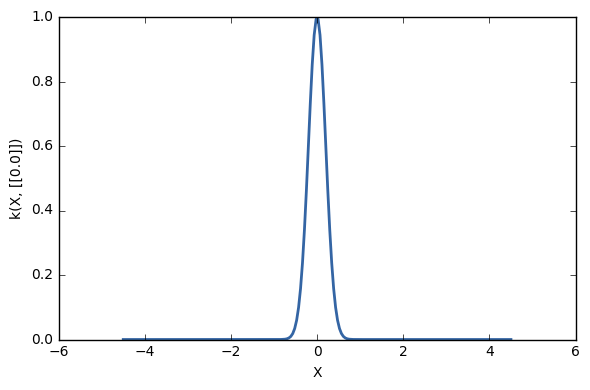

In [4]:
k.plot()

## Setting Covariance Function Parameters

The value of the covariance function parameters can be accessed and modified using `k['.*var']` where the string in brackets is a regular expression matching the parameter name as it appears in `print k`. You can also access each parameter directly:

In [5]:
print(k.lengthscale)
k['.*lengthscale']

  index  |  rbf.lengthscale  |  constraints  |  priors
  [0]    |       0.20000000  |      +ve      |        


index,rbf.lengthscale,constraints,priors
[0],0.20000000,+ve,


Let's use this to get an insight into the effect of the parameters on the shape of the covariance function, by setting the lengthscale of the covariance function to different values, and plotting the resulting covariance using the `k.plot()` method.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


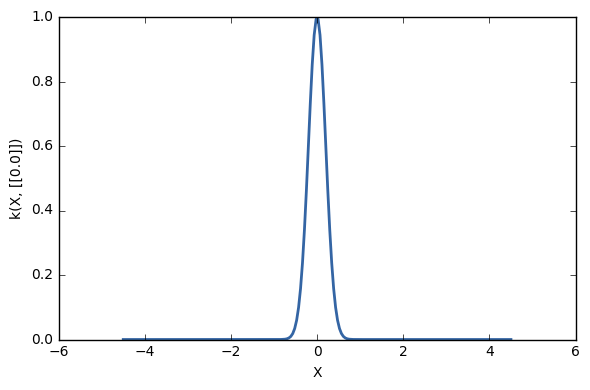

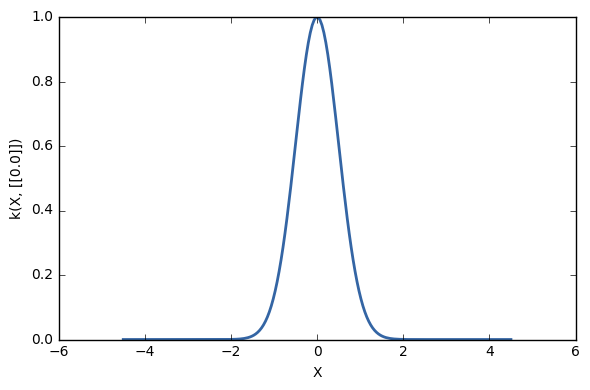

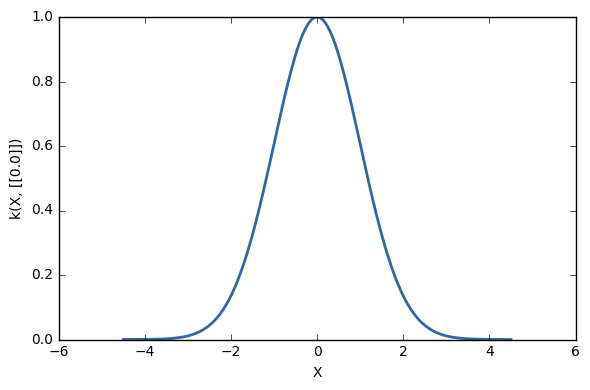

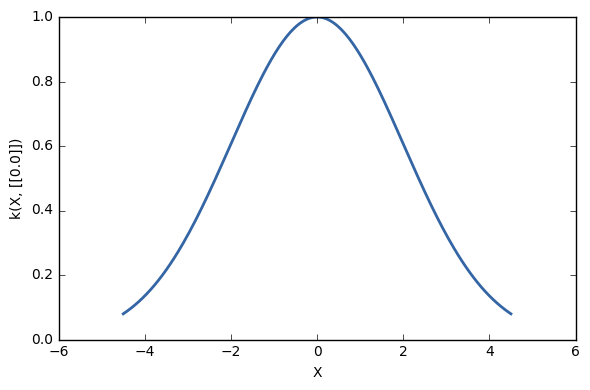

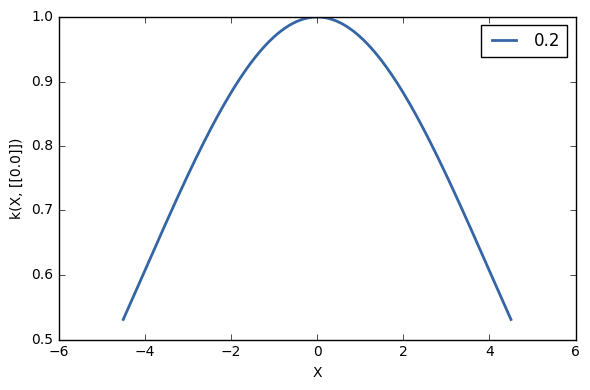

In [6]:
k = GPy.kern.RBF(d)     # By default, the parameters are set to 1.
theta = np.asarray([0.2,0.5,1.,2.,4.])
for t in theta:
    k.lengthscale=t
    k.plot()
plt.legend(theta)

### Exercise 1

a) What is the effect of the lengthscale parameter on the covariance function?

b) Now change the code above to investigate the effect of changing the variance parameter.

In [7]:
# Exercise 1 b) answer


## Covariance Functions in GPy

Many different covariance functions are already implemented in GPy. Instead of rbf, try constructing and plotting the following  covariance functions: `exponential`, `Matern32`, `Matern52`, `Brownian`, `linear`, `bias`,
`rbfcos`, `periodic_Matern32`, etc. Some of these covariance functions, such as `rbfcos`, are not
parametrized by a variance and a lengthscale. Furthermore, not all kernels are stationary (i.e., they can’t all be written as $k ( x, y) = k ( x − y)$, see for example the Brownian
covariance function). For plotting  so it may be interesting to change the value of the fixed input:

(-0.1, 5.1)

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


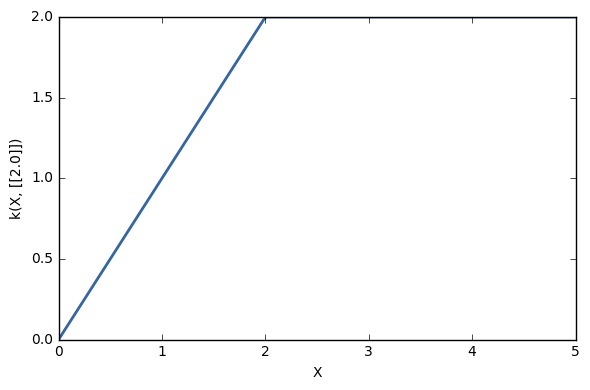

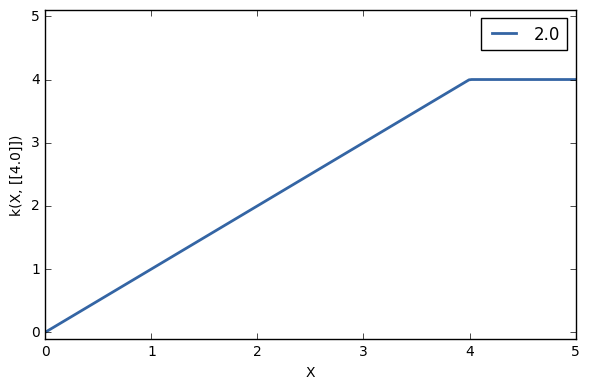

In [8]:
kb = GPy.kern.Brownian(input_dim=1)
inputs = np.array([2., 4.])
for x in inputs:
    kb.plot(x,plot_limits=[0,5])
plt.legend(inputs)
plt.ylim(-0.1,5.1)

### Exercise 2

Plot some other covariance functions. As we will see, it is very hard to intuit from the shape of these what the resulting GP sample paths will look like. 



## Computing the covariance/Gram matrix given the input data, $\mathbf{X}$

Let $\mathbf{X}$ be a $n$ × $d$ numpy array. Given a kernel $k$, the covariance matrix associated to
$\mathbf{X}$ is obtained with `C = k.K(X,X)` . The positive semi-definiteness of $k$ ensures that `C`
is a positive semi-definite (psd) matrix regardless of the initial points $\mathbf{X}$. This can be
checked numerically by looking at the eigenvalues (they should all be positive if C is positive definite):

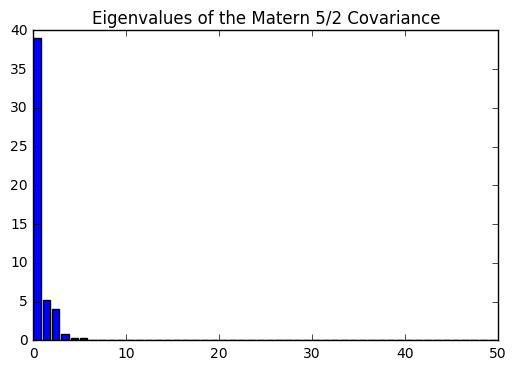

In [9]:
k = GPy.kern.Matern52(input_dim=2)
X = np.random.rand(50,2)       # 50*2 matrix of iid standard Gaussians
C = k.K(X,X)
eigvals = np.linalg.eigvals(C)           # Computes the eigenvalues of a matrix
plt.bar(np.arange(len(eigvals)), eigvals)
plt.title('Eigenvalues of the Matern 5/2 Covariance')

## 2. Prior Simulation

Gaussian processes can be used as infinite dimensional models of function. They are defined by a covariance *function* and a mean *function*. 

When we compute the covariance matrix using `kern.K(X, X)` we are computing a covariance *matrix* between the values of the function, $f$, that correspond to the input locations in the matrix `X`. If we want to have a look at the type of functions that arise from a particular Gaussian process, we can never generate all possible values, but we can generate random samples from a Gaussian *distribution* based on a covariance matrix associated with a particular matrix of input locations `X`. If these locations are chosen appropriately then they give us a good idea of the underlying function. For example, for a one dimensional function, if we choose `X` to be uniformly spaced across part of the real line, and the spacing is small enough, we'll get an idea of the underlying function. We will now use this trick to draw sample paths from a Gaussian process. 

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning:covariance is not positive-semidefinite.


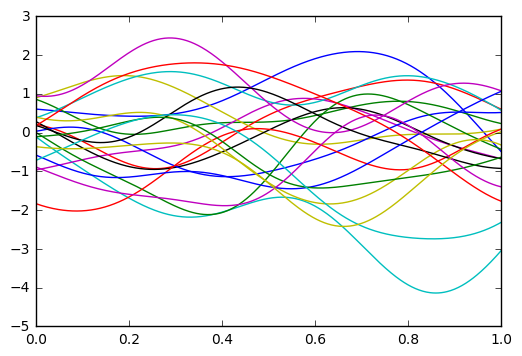

In [10]:
k = GPy.kern.RBF(input_dim=1,lengthscale=0.2)

X = np.linspace(0.,1.,500) # define X to be 500 points evenly spaced over [0,1]
X = X[:,None] # reshape X to make it n*p 

mu = np.zeros((500)) # vector of the means --- we could use a mean function, but here it is just zero.
C = k.K(X,X) # compute the covariance matrix associated with inputs X

# Generate 20 separate samples paths from a Gaussian with mean mu and covariance C
Z = np.random.multivariate_normal(mu,C,20)

plt.figure()     # open a new plotting window
for i in range(20):
    plt.plot(X[:],Z[i,:])

Our choice of `X` means that the points are close enough together to look like functions. We can see the structure of the covariance matrix we are plotting from if we visualize C.

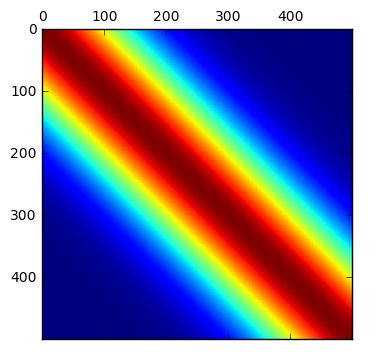

In [11]:
plt.matshow(C)

### Exercise 3: 
Try a range of different covariance functions and hyper-parameter values and plot the corresponding sample paths for each using the same approach given above. Compare these to the shapes of the covariance functions you found in Exercise 2. Can you see any relationship?

In [12]:
# Try plotting sample paths here

### Exercise 4:

The sample paths from a GP inherit their properties (such as continuity, differentiability, smoothness etc) from the particular covariance function used.

Can you tell the covariance structures 
that have been used for generating the
sample paths shown in the figure below?
<br>
<center>
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figa.png" alt="Figure a" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figb.png" alt="Figure b" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figc.png" alt="Figure c" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figd.png" alt="Figure d" style="width: 30%;">
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/fige.png" alt="Figure e" style="width: 30%;"> 
<img src="http://ml.dcs.shef.ac.uk/gpss/gpws14/figf.png" alt="Figure f" style="width: 30%;">
</center>


## 3. A Gaussian Process Regression Model

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = 0.3\cos(1.3 x ) + \sin(0.3x )$ over $[0, 10]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

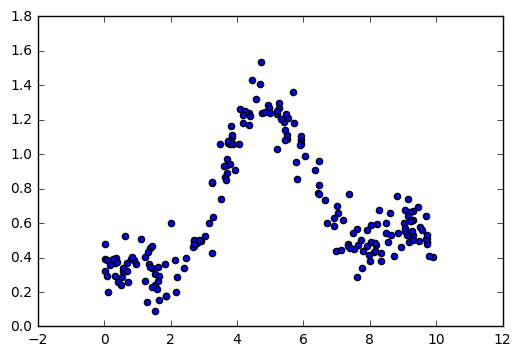

In [13]:
X = np.random.uniform(0, 10, (200, 1))
f = np.sin(.3*X) + .3*np.cos(1.3*X)
Y = f+np.random.normal(0, .1, f.shape)
plt.scatter(X, Y)


A GP regression model based on an exponentiated quadratic covariance function can be defined by first defining a covariance function, 

In [14]:
k = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)

And then combining it with the data to form a Gaussian process model,

In [15]:
m = GPy.models.GPRegression(X,Y,k)
print(m)


Name : GP regression
Objective : 199.15646490667305
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Just as for the covariance function object, we can find out about the model using the command `print m`. 

In [16]:
print(m)


Name : GP regression
Objective : 199.15646490667305
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Note that by default the model includes some observation noise
with variance 1. We can see the posterior mean prediction and visualize the marginal posterior variances using `m.plot()`.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


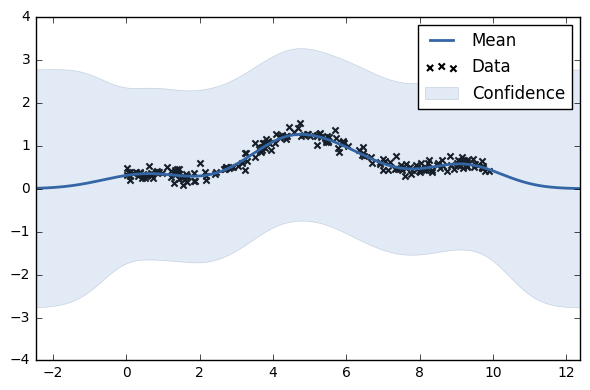

In [17]:
m.plot()

The actual predictions of the model for a set of points `Xstar`
(an $m \times p$ array) can be computed using 

`Ystar, Vstar = m.predict(Xstar)`

In [18]:
Xp = np.linspace(-2,12)[:,None]
Ystar, Vstar = m.predict(Xp, full_cov=True)
up95, lo95 = m.predict_quantiles(Xp, quantiles=(2.5,97.5))


Note that the inputs to GPy need to be 2-d arrays.

In [19]:
Xp = np.linspace(-2,12)[:,np.newaxis]

### Exercise 5

a) What do you think about this first fit? Does the prior given by the GP seem to be
adapted?

b) The parameters of the models can be modified using a regular expression matching the parameters names (for example `m['.*noise'] = 0.001` ), or by `m.Gaussian_noise.variance=0.001`. Change the values of the parameters to obtain a better fit, replotting your fitted model.

In [20]:
# Exercise 4 b) answer

c) As in Section 2, random sample paths from the conditional GP can be obtained using
`np.random.multivariate_normal(mu[:,0],C)` where the mean vector and covariance
matrix `mu` and `C` are obtained through the predict function `mu, C = m.predict(Xp,full_cov=True)`. Obtain 10 samples from the posterior sample and plot them alongside the data below.

In [21]:
# Exercise 4 c) answer

Note that the `GPy.models` commands are wrappers for a collection of commands. `GPRegression` makes two default choices here:

1. Specifies a Gaussian likelihood, i.e., we assume that $y=f(x) + e$ where $f$ is the GP, and $e\sim N(0, \sigma^2)$ is the Gaussian noise term (referred to as the likelihood in GPy), sometimes called a **nugget** in spatial statistics.
2. Specifies an inference scheme, i.e., a way of calculating the posterior distribution of $f$ given the training data. Because we are using a Gaussian likelihood here, the posterior distribution of $f$ is also a Gaussian process, and so inference can be done exactly.

We could equivalently set up the model using the following:


In [22]:
gauss = GPy.likelihoods.Gaussian(variance=1.0)
exact = GPy.inference.latent_function_inference.ExactGaussianInference()
m1 = GPy.core.GP(X=X, Y=Y, kernel=k, likelihood=gauss, inference_method=exact)
print(m1)


Name : gp
Objective : 199.15646490667305
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


### Covariance Function Parameter Estimation

As we have seen during the lectures, the parameters values can be estimated by maximizing the likelihood of the observations. Since we don’t want one of the variance to become negative during the optimization, we can constrain all parameters to be positive before running the optimisation.

In [23]:
m.constrain_positive()

The warnings are because the parameters are already constrained by default, the software is warning us that they are being reconstrained.

Now we can optimize the model using the `m.optimize()` method. A number of optimizers are available, such as 'scg', 'lbfgs', 'org-bfgs', 'fmin_tnc', as well as stochastic optimizers if a dependency on a package 'climin' is satisfied, such as 'adadelta' and 'rprop'.


Name : GP regression
Objective : -151.23345681629752
Number of Parameters : 1
Number of Optimization Parameters : 1
Updates : True
Parameters:
  GP_regression.           |             value  |  constraints  |  priors
  Gaussian_noise.variance  |  0.00895683789669  |      +ve      |        


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


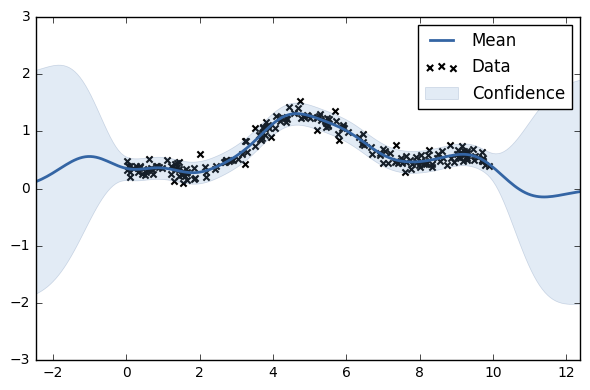

In [24]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed
m.plot()
print(m)

The parameters obtained after optimisation can be compared with the values you selected by hand. As previously, you can modify the kernel used for building the model to investigate its influence on the model.

Note what has happened outside the range of the data: the GP prediction returns to its prior mean value of 0. We could fix this by adding a prior mean.

## Problems with hyper-parameter optimization

Unfortunately, optimization of GP hyper-parameters is not always without problems. The likelihood surface that is being maximized is often flat and multi-modal, and thus the optimizer can sometimes fail to converge, or gets stuck in local-maxima. You can see from the optimization output above, that the gradients at the optima are very small ($10^{-18}$), but not necessarily zero. This kind of problem is due to the use of numerical optimization. When using GPs this can type of problem is common, and so we must always sanity check our answers, and ideally run some diagnostic tests on the fitted model.

As an example, consider


In [25]:
np.random.seed(16)
X = np.linspace(0.05,0.95,10)[:,None]
Y = -np.cos(np.pi*X) + np.sin(4*np.pi*X) + np.random.normal(loc=0.0, scale=0.1, size=(10,1)) 

If we now fit a GP and optimize the hyper parameters, you may find some problems.

 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


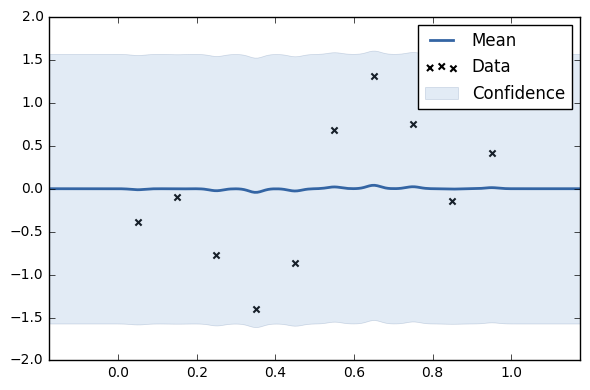

In [26]:
m = GPy.models.GPRegression(X,Y) # this will automatically use a RBF covariance function
m.optimize(messages=1)
m.plot()

### Exercise 5:
What may have happened here?


One way to fix this is to change the parameter settings so that the optimizer starts in a more sensible location as described above. 

Another option is to run the optimizer multiple times from multiple different starting points, and pick the best possible (I'd recommend this as good practice). This can be done in GPy as follows:

Optimization restart 1/10, f = 11.96887713535652
Optimization restart 2/10, f = 7.969923622373031
Optimization restart 3/10, f = 7.969923622373408
Optimization restart 4/10, f = 7.969923622374876
Optimization restart 5/10, f = 11.968877507245928
Optimization restart 6/10, f = 7.969923622373341
Optimization restart 7/10, f = 7.969923622373198
Optimization restart 8/10, f = 7.969923622377622
Optimization restart 9/10, f = 7.96992362237698
Optimization restart 10/10, f = 7.969923622373035


 /Users/pmzrdw/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1742: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


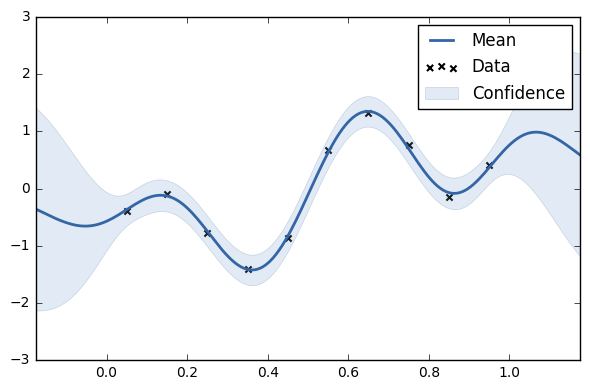

In [27]:
m.optimize_restarts(10) # try 10 different starting locations 
m.plot()

The fit chosen is the one with the highest maximum likelihood. This is not always what we want, and so we may choose to use methods such as looking at prediction error on a held out dataset, or cross-validation to choose the hyper parameters.  

We can also do things like fix certain parameters, constrain them to lie in a given range, and put prior distributions over them. Notice how this information is reported when you type `print(m)`.


Name : GP regression
Objective : 12.012149258332974
Number of Parameters : 3
Number of Optimization Parameters : 2
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |     priors   
  rbf.variance             |   1.42852320245  |      +ve      |  Ga(3.2, 2.1)
  rbf.lengthscale          |  0.200000007687  |    0.2,1.0    |              
  Gaussian_noise.variance  |             0.1  |   +ve fixed   |              


 /Users/pmzrdw/GPy/GPy/core/parameterization/priors.py:301: RuntimeWarning:divide by zero encountered in log


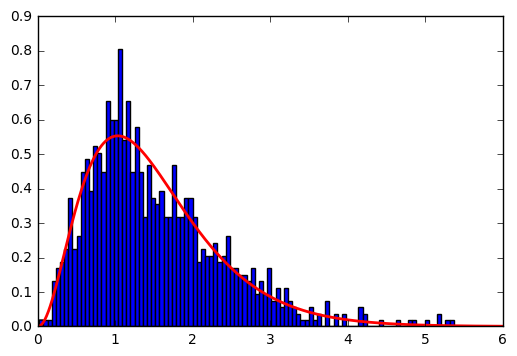

In [28]:
m.Gaussian_noise.variance.fix(0.1)
m.rbf.lengthscale.constrain_bounded(lower=0.2, upper=1)

gamma_prior = GPy.priors.Gamma.from_EV(1.5, 0.7)
gamma_prior.plot()
m.rbf.variance.set_prior(gamma_prior)
m.optimize()
print(m)

To remoe these constraints and priors, we can do something like the following:

In [29]:
m.unconstrain()
m.rbf.variance.unset_priors()
print(m)
m.constrain_positive() # we've removed the postive constraint above, so we should reset this constraint.



Name : GP regression
Objective : 11.016765214370487
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |           value  |  constraints  |  priors
  rbf.variance             |   1.42852320245  |               |        
  rbf.lengthscale          |  0.200000007687  |               |        
  Gaussian_noise.variance  |             0.1  |               |        


### Exercise 6:
Generate some data from the model $$y = x*sin(x)+e \qquad e \sim N(0,0.1^2)$$ for x in the range $[0,5]$. Fit a GP regression model. Do your hyperparameter estimates look reasonable? Try constraining the noise variance to be $0.1^2$. Predict the function in the range $[-5,10]$. Do your predictions look reasonable? What could you do to fix this?